## Transfer Learning from CNN 


### Method 1
- Data preprocess the same way for input
- try the same thing as tf_layer2 but with unet 

### Bench Marks
**Final Result for Random Forest trained on SOCAT**

Test Set RMSE: 30.56 | Whole Grid Rmse: 42.12


**Final Result for XGBoost trained on SOCAT**

Test Set RMSE:28.43698261274142 | Whole Grid Rmse:37.709863752151215

### Result

Test Set RMSE:  | Whole Grid RMSE: 


In [58]:
tf.keras.backend.clear_session()

In [2]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-03-27 16:18:28.824494: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[(y_true != 0) & (y_true != 0.0)]
    y_true = y_true[(y_true != 0) & (y_true != 0.0)]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [4]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images(dir_name)
data_socat, pco2_socat = preprocess_images(dir_name, socat = True)

val_data,val_pco2 = preprocess_images(val_dir_name,"035")
val_data_socat,val_pco2_socat = preprocess_images(val_dir_name,"035",socat=True)


/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
INPUT_SHAPE=data_socat[0].shape
OUTPUT_SHAPE=pco2_socat[0].shape

INPUT_SHAPE

(180, 360, 5)

In [59]:
from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPool2D , Flatten, Input

base_model = tf.keras.models.load_model('../../models/base_model/base_model_new.h5', custom_objects={'custom_rmse':custom_rmse})


In [60]:
for layer in base_model.layers[:-3]:
    layer.trainable = False

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 180, 360, 128)     0

In [61]:
base_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-5),
)

model_path="../../models/transfer_CNN.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 150
batch_size = 16

In [ ]:
history = base_model.fit(
    data_socat,
    pco2_socat,
    batch_size=batch_size,
    epochs=epochs,
    workers=-1,
    validation_data=(data_socat, pco2_socat),
    callbacks=callbacks,
)

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(history.history["val_loss"])
plt.ylabel('val_loss')
plt.xlabel('epoch')

### Assessing Performance of SOCAT

In [8]:
best_model = tf.keras.models.load_model('../../models/transfer_CNN.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_frames=best_model.predict(data_socat,verbose=1)
predicted_frames[pco2_socat==0]=0.0

2022-03-27 16:20:03.618631: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-27 16:20:03.824306: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz
2022-03-27 16:20:05.898716: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-03-27 16:21:29.505141: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-27 16:21:33.066323: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


14/14 [==============================] - 94s 156ms/step


In [9]:
predicted_frames[0].shape

(180, 360)

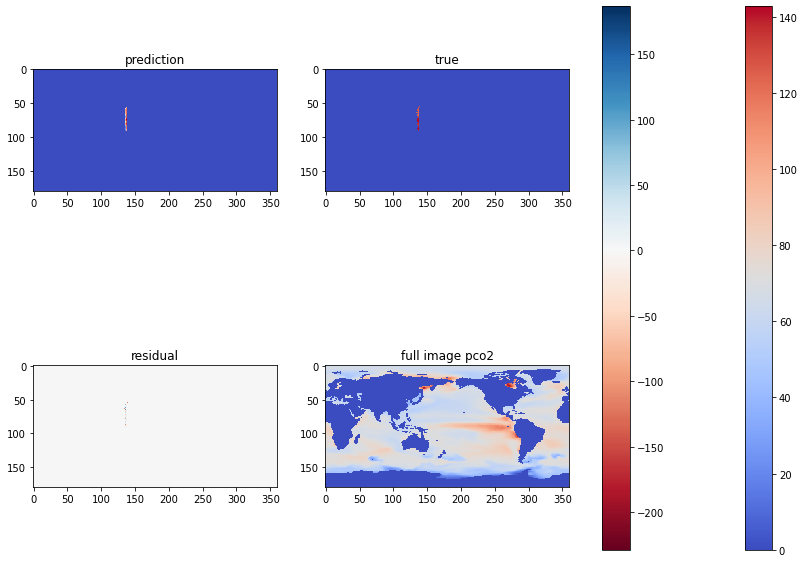

In [10]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 2,figsize=(15, 10))

d = predicted_frames - pco2_socat
norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)



img=axis[0][0].imshow(np.flipud(predicted_frames[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(pco2_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(predicted_frames[0]-pco2_socat[0]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(pco2[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("full image pco2")

#plt.savefig('../../assets/transfer_nfp.png')

plt.show()

### Inverse

In [29]:
def inverse_scale_image_socat(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """    
    old_min = 0
    old_max = np.nanmax(df)
    y_pred = arr*(old_max-old_min)/255
    
    tmp=np.nan_to_num(df)
    y_true = tmp
    y_pred[y_true==0] = 0
    return y_true,y_pred

In [31]:
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2t = read_xarray(dir_name)

y_true,y_pred = inverse_scale_image_socat(predicted_frames,pco2t.pCO2_socat.data)  

old_max: 635.2041036748


In [41]:
custom_rmse(predicted_frames,pco2_socat)

<tf.Tensor: shape=(), dtype=float64, numpy=7.096111343843909>

In [42]:
print("SOCAT RMSE score:")
custom_rmse(y_pred,y_true)

SOCAT RMSE score:


<tf.Tensor: shape=(), dtype=float64, numpy=108.4415990207539>

### Assessing Performance of Full

In [26]:
predicted_frames=best_model.predict(data,verbose=1)
predicted_frames[pco2==0]=0.0

14/14 [==============================] - 2s 122ms/step


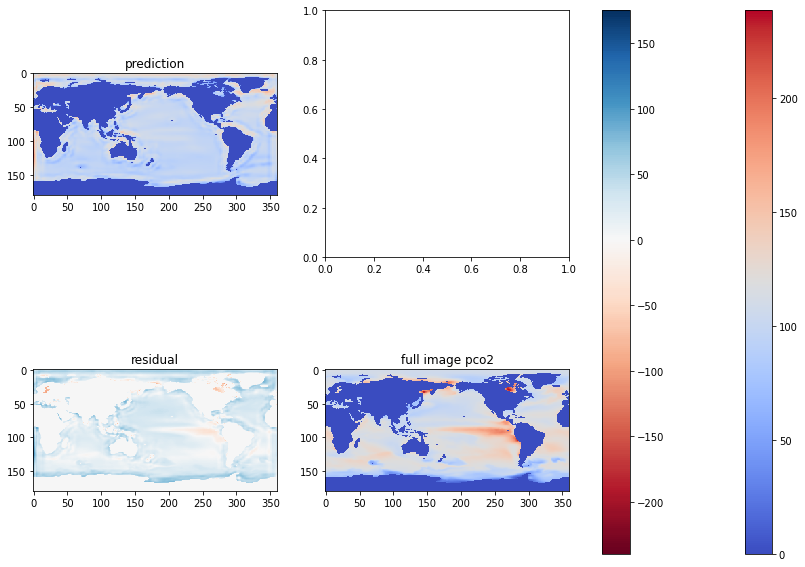

In [27]:
figure, axis = plt.subplots(2, 2,figsize=(15, 10))

d = predicted_frames - pco2
norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(predicted_frames[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

diff=np.flipud(np.squeeze(predicted_frames[0]-pco2[0]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(pco2[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("full image pco2")

#plt.savefig('../../assets/transfer_nfp.png')

plt.show()

In [32]:
y_true,y_pred=inverse_scale_image_socat(predicted_frames,pco2t.pCO2.data)  
print("Full RMSE score:")
custom_rmse(y_pred,y_true)

old_max: 831.1136616134033
Full RMSE score:


<tf.Tensor: shape=(), dtype=float64, numpy=61.4494787917662>

In [33]:
custom_rmse(predicted_frames,pco2)

<tf.Tensor: shape=(), dtype=float64, numpy=28.801675928464565>